# МО для HR-аналитики компании

Проект посвящён разработке двух моделей машинного обучения, которые помогут HR-аналитикам компании предсказывать уровень удовлетворённости сотрудника и вероятность увольнения. Для исследования нужно будет составить портрет «уволившегося сотрудника» и добавить новый входной признак 'job_satisfaction_rate'. 

In [1]:
# загружаю все нужные для проекта библиотеки

!pip install shap 
!pip install phik
!pip install --upgrade scikit-learn

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import shap
import phik

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [2]:
def load_data(file_name):
    """
    Load data from a CSV file and display its head and info.

    This function reads a CSV file, with data separated by semicolons and decimals
    denoted by commas, into a pandas DataFrame. It also displays the first few rows of the
    DataFrame (the head) and summarizes the columns.

    Parameters
    ----------
    file_name : str
        The name (and path, if necessary) of the CSV file from which to load data.

    Returns
    -------
    data : pandas.DataFrame
        The data loaded from the CSV file.
    """
    data = pd.read_csv(file_name)  # разделила данные в датасете по столбцам и поправила разделитель в дробях
    print(data.head())
    data.info()
    return data


def clean_columns(data):
    """
    Cleans the column names of a pandas DataFrame.

    :param data: The pandas DataFrame to clean the column names of.
    :type data: pandas.DataFrame
    :return: The pandas DataFrame with cleaned column names.
    :rtype: pandas.DataFrame
    """
    data.columns = data.columns.str.lower().str.replace(' ', '_')
    print(data.head())
    return data

def plot_cat_data(data, column, hue, title, ax):
    """
    Plot a countplot for the given categorical data.

    Parameters
    ----------
    data : array-like
        The categorical data to be plotted as a countplot. This could be a list, 1D-array or series.
    title : string
        The title of the plot.
    ax : matplotlib.axes.Axes instance
        The axes upon which to draw the plot.

    Returns
    -------
    None
    """
    sns.countplot(x=data[column], hue=data[hue], ax=ax)
    ax.set_title(title)

def plot_num_data(data, x, hue, title, ax):
    """
    Plot a boxplot (also known as whisker plot) for the given numerical data.

    Parameters
    ----------
    data : array-like
        The numerical data to be plotted as a boxplot. This could be a list, 1D-array or series.
    title : string
        The title of the plot.
    ax : matplotlib.axes.Axes instance
        The axes upon which to draw the plot.

    Returns
    -------
    None
    """
    sns.boxplot(data=data, x=x, y=hue, ax=ax) # ящик с усами
    ax.set_title(title)

def hist_num_data(data, x, hue, title, ax):
    """
    Plot a histogram of the given data.

    Parameters
    ----------
    data : array-like
        The input data to be plotted as a histogram.
    title : str
        The title to be set for the histogram.
    ax : matplotlib.axes.Axes
        The axes object on which the histogram is to be plotted.

    Returns
    -------
    None
    """
    sns.histplot(data=data, x=x, hue=hue, ax=ax) # гистограмма
    ax.set_title(title)


## Загрузка и изучение данных для первой модели

In [3]:
try:
    job_satisfaction_rate = load_data('/Users/ira-bobrineva/Downloads/train_job_satisfaction_rate.csv')
except:
    job_satisfaction_rate = load_data('/datasets/train_job_satisfaction_rate.csv')


       id        dept   level workload  employment_years last_year_promo  \
0  155278       sales  junior   medium                 2              no   
1  653870          hr  junior     high                 2              no   
2  184592       sales  junior      low                 1              no   
3  171431  technology  junior      low                 4              no   
4  693419          hr  junior   medium                 1              no   

  last_year_violations  supervisor_evaluation  salary  job_satisfaction_rate  
0                   no                      1   24000                   0.58  
1                   no                      5   38400                   0.76  
2                   no                      2   12000                   0.11  
3                   no                      2   18000                   0.37  
4                   no                      3   22800                   0.20  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 

In [4]:
try:
    test_features = load_data('/Users/ira-bobrineva/Downloads/test_features.csv')
except:
    test_features = load_data('/datasets/test_features.csv')

       id       dept   level workload  employment_years last_year_promo  \
0  485046  marketing  junior   medium                 2              no   
1  686555         hr  junior   medium                 1              no   
2  467458      sales  middle      low                 5              no   
3  418655      sales  middle      low                 6              no   
4  789145         hr  middle   medium                 5              no   

  last_year_violations  supervisor_evaluation  salary  
0                   no                      5   28800  
1                   no                      4   30000  
2                   no                      4   19200  
3                   no                      4   19200  
4                   no                      5   40800  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   

In [5]:
try:
    test_target_job_satisfaction_rate = load_data('/Users/ira-bobrineva/Downloads/test_target_job_satisfaction_rate.csv')
except:
    test_target_job_satisfaction_rate = load_data('/datasets/test_target_job_satisfaction_rate.csv')

       id  job_satisfaction_rate
0  130604                   0.74
1  825977                   0.75
2  418490                   0.60
3  555320                   0.72
4  826430                   0.08
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Полных дубликатов в данных нет, со столбцами всё хорошо, только есть пропущенные значения в некоторых. Обработаю их с помощью SimpleImputer в пайплайне.

## Исследовательский анализ

In [6]:
job_satisfaction_rate

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


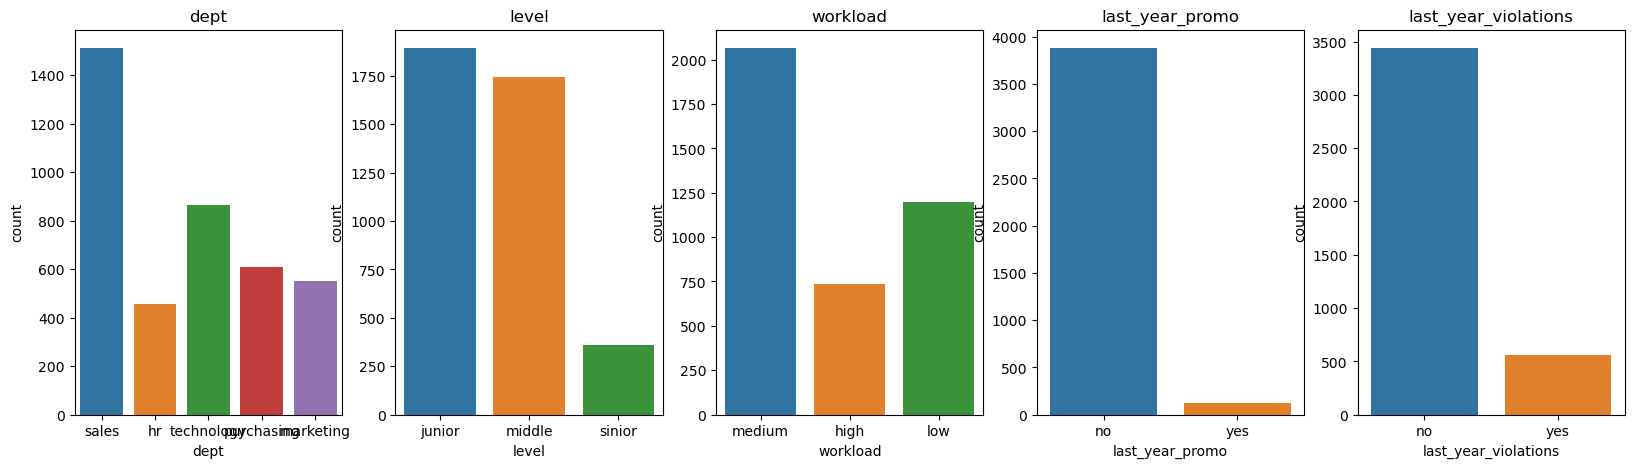

In [7]:
job_satisfaction_cat = job_satisfaction_rate[['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']]

fig, axs = plt.subplots(1, len(job_satisfaction_cat.columns), figsize=(20, 5))

for i, cat in enumerate(job_satisfaction_cat):
    # строю столбчатые диаграммы
    sns.countplot(x=job_satisfaction_cat[cat], ax=axs[i])
    axs[i].set_title(cat)

В компании очень маленький процент повышений за прошлый год. Это может плохо сказываться на мотивации сотрудников.

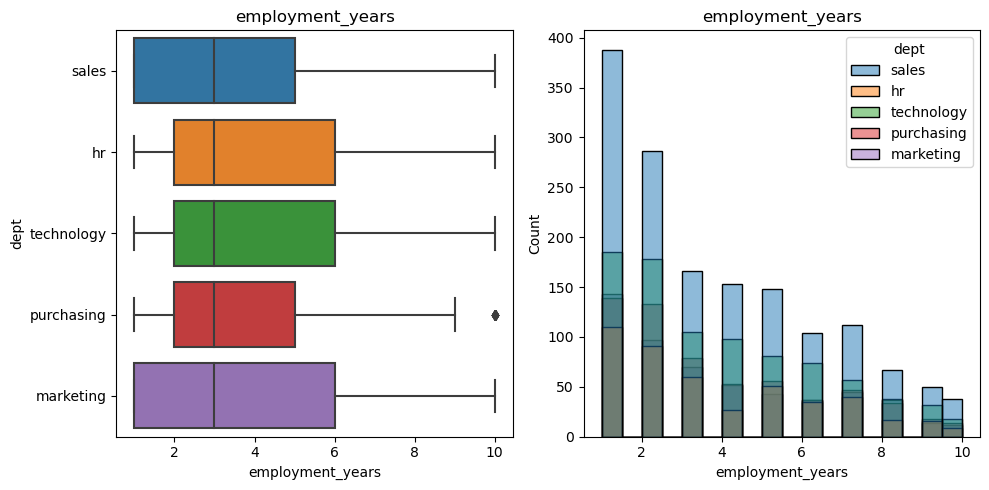

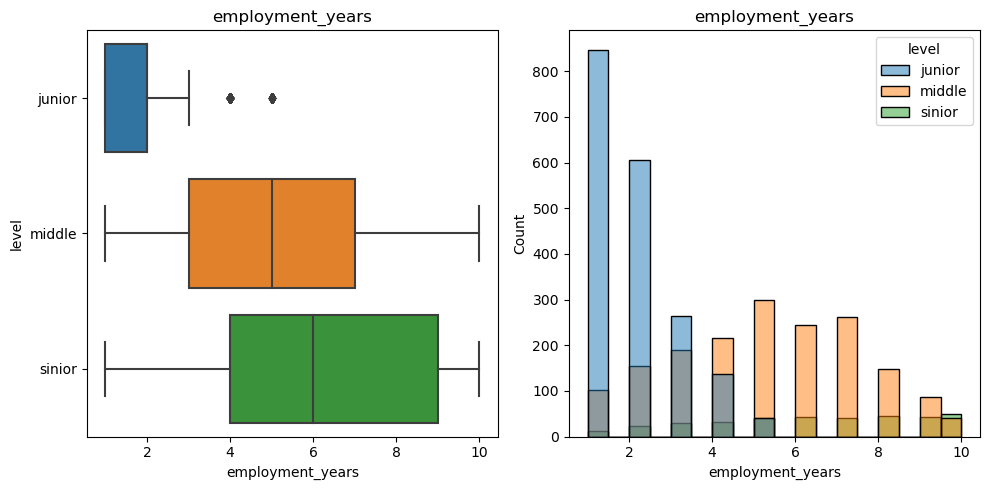

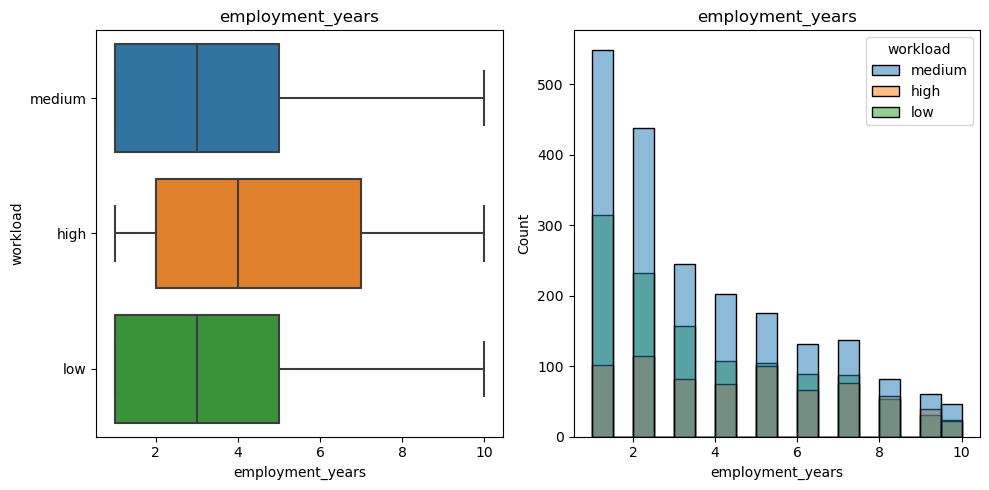

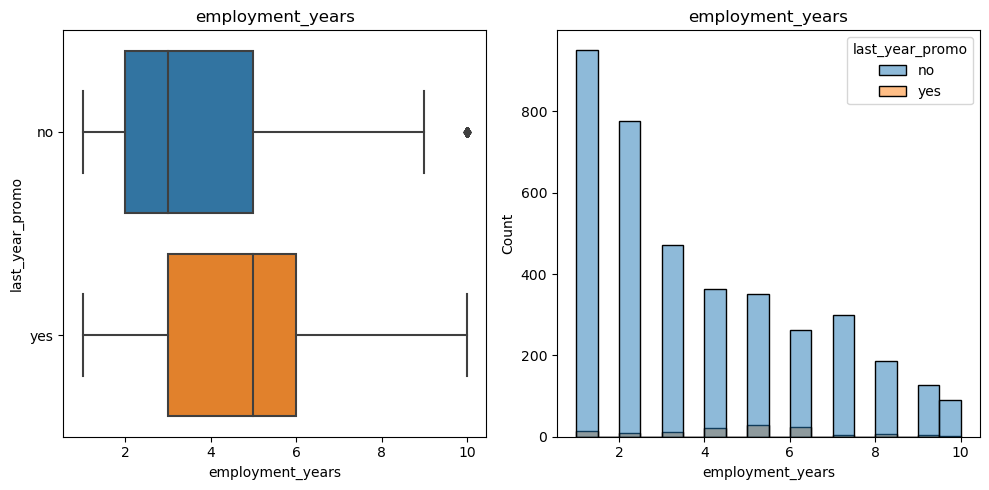

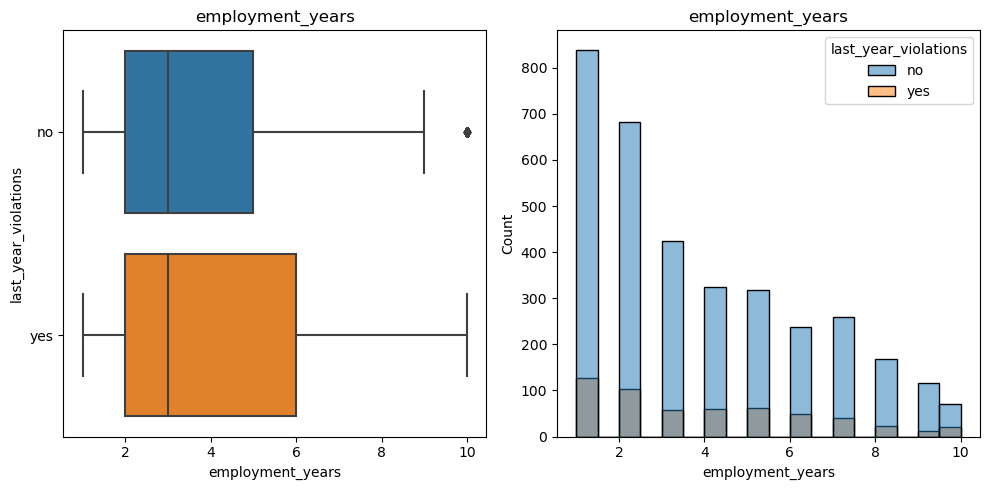

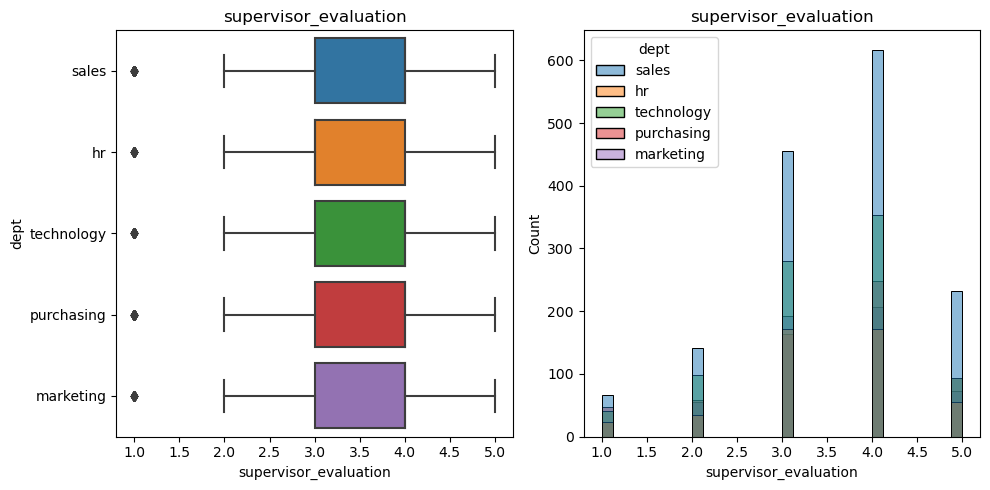

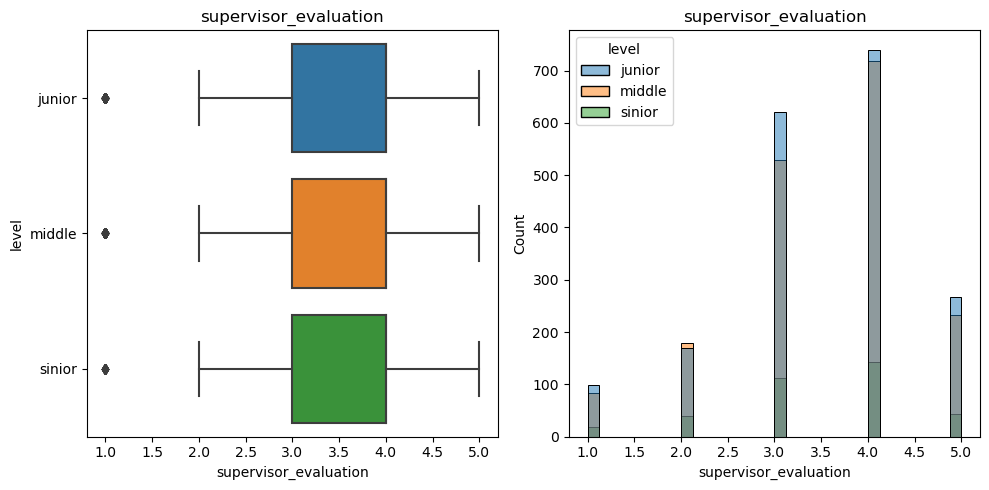

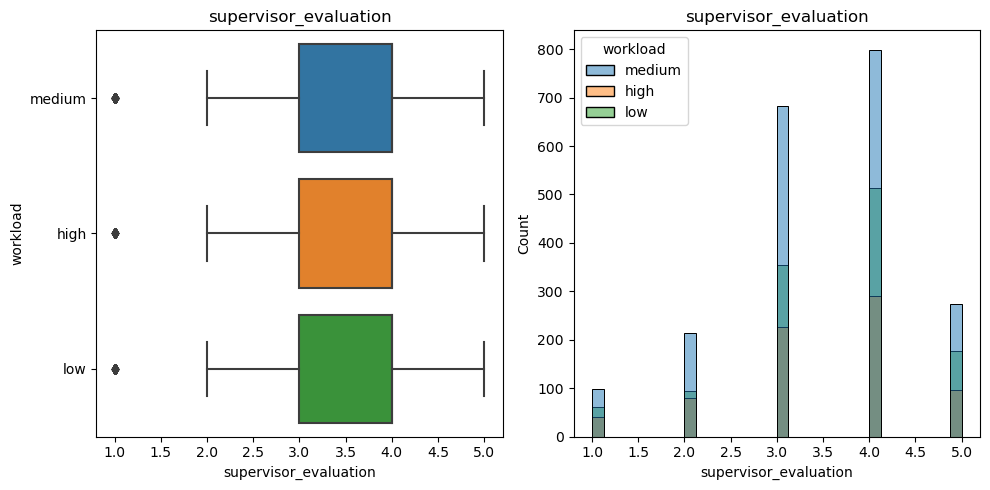

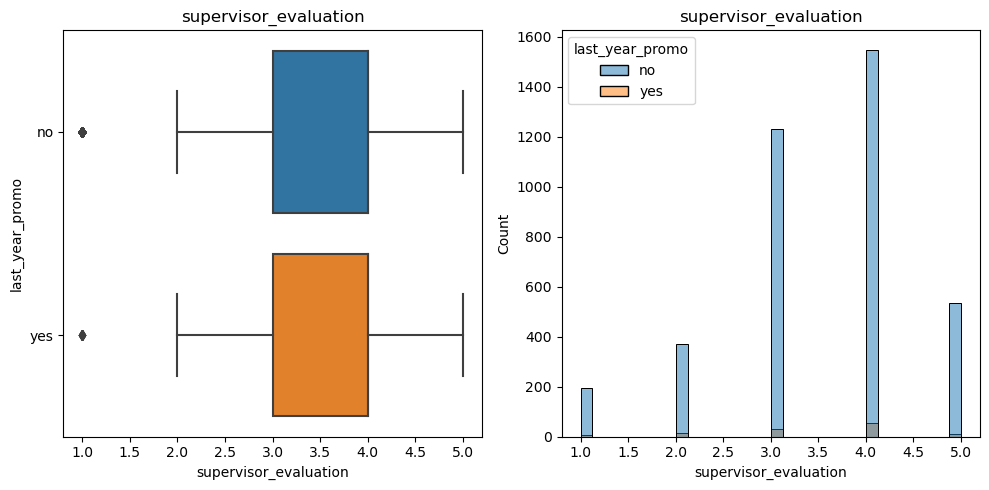

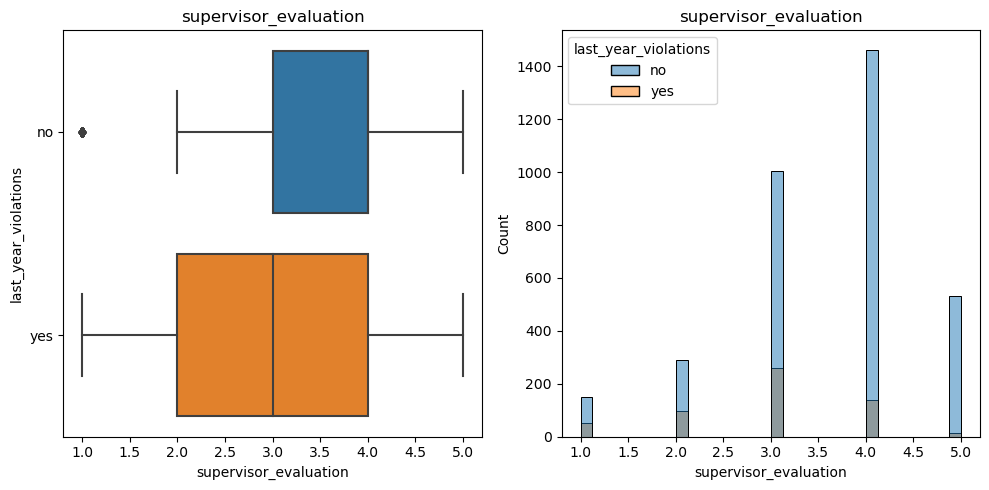

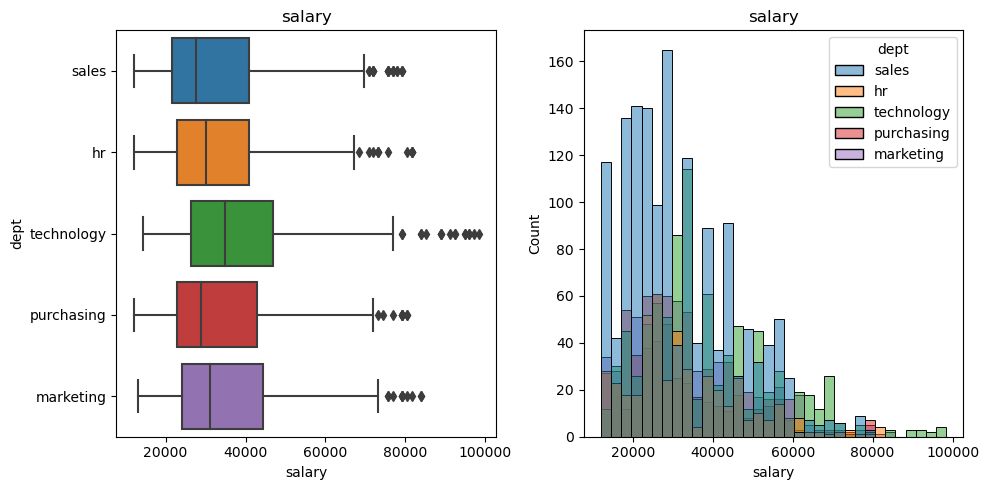

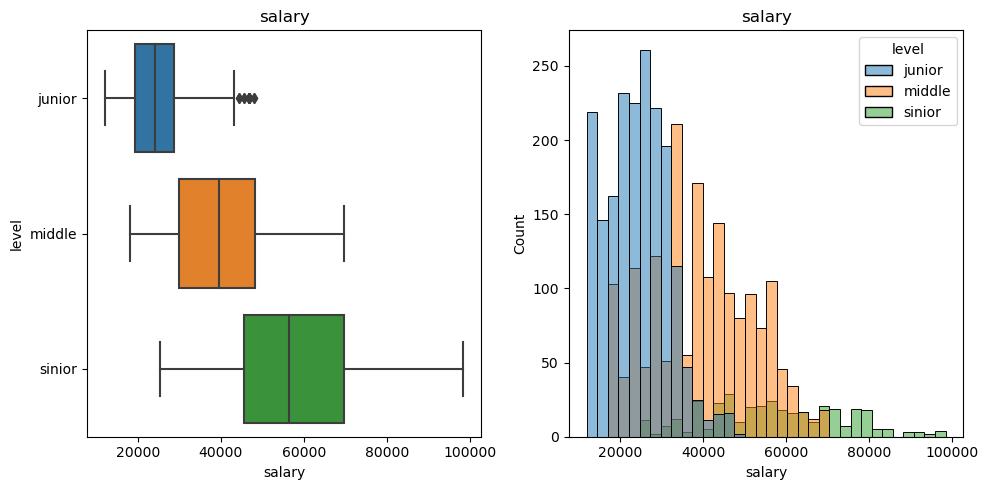

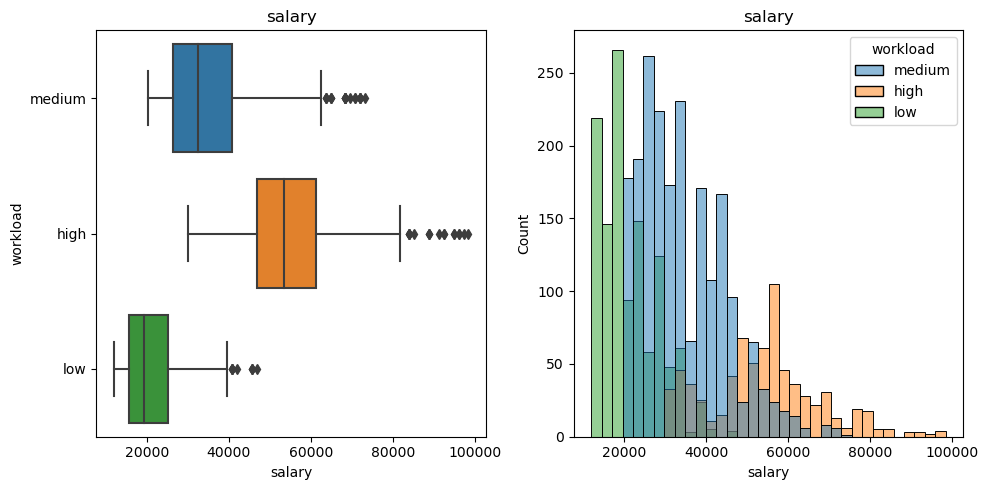

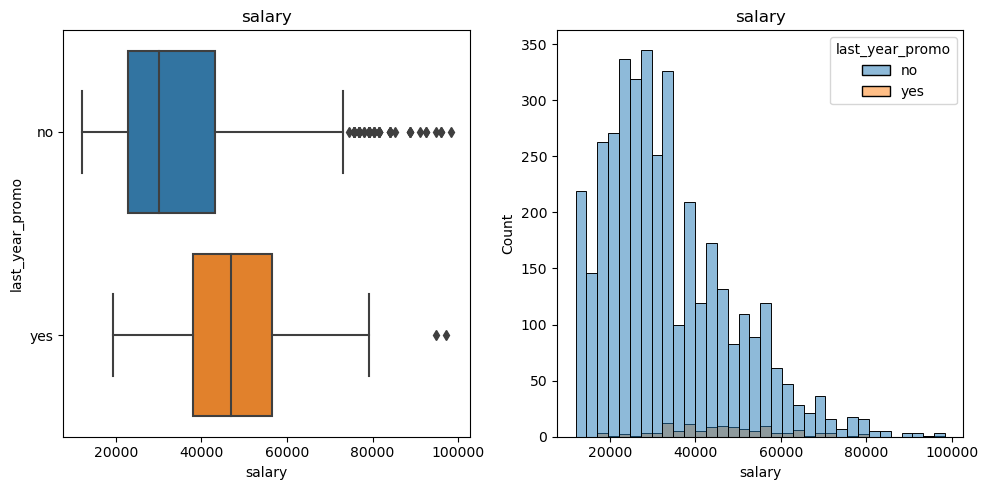

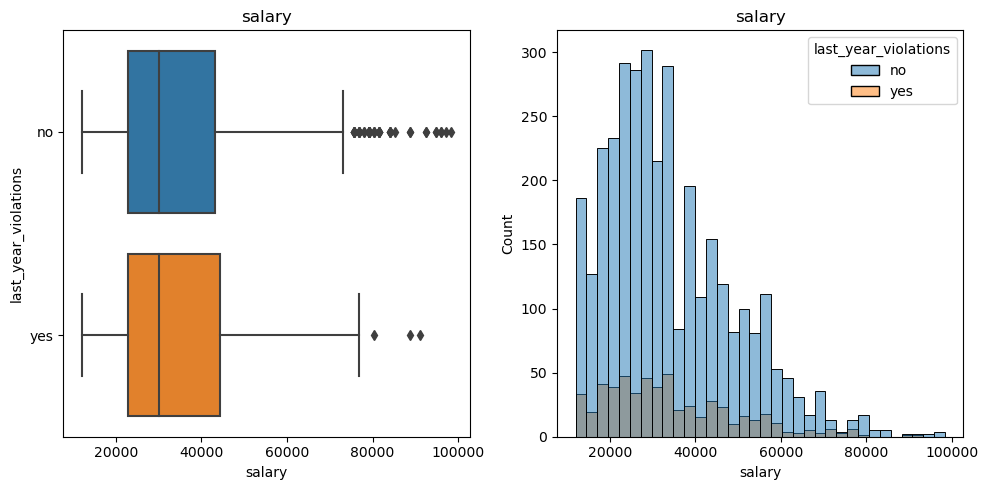

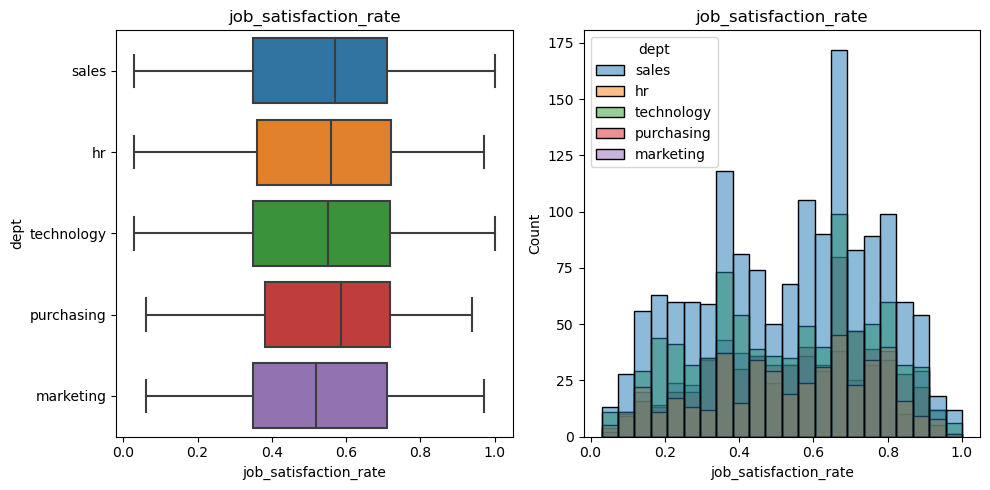

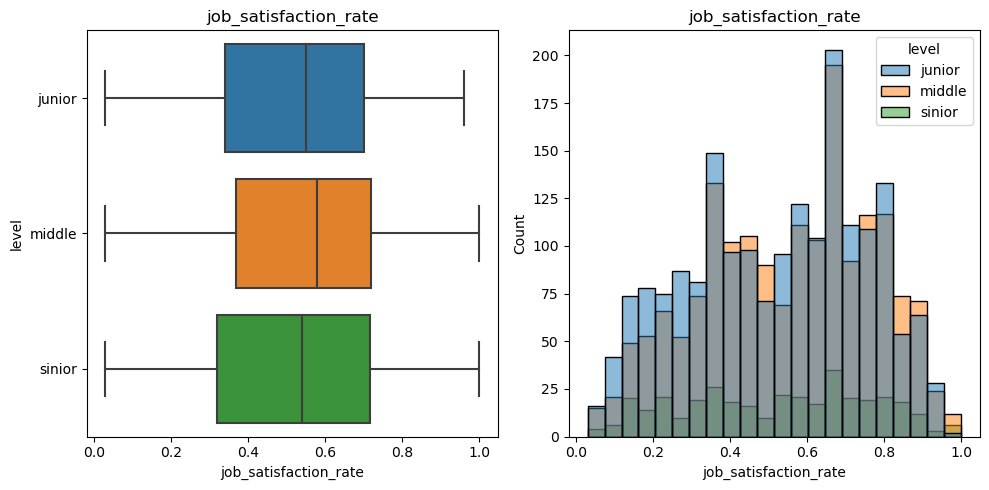

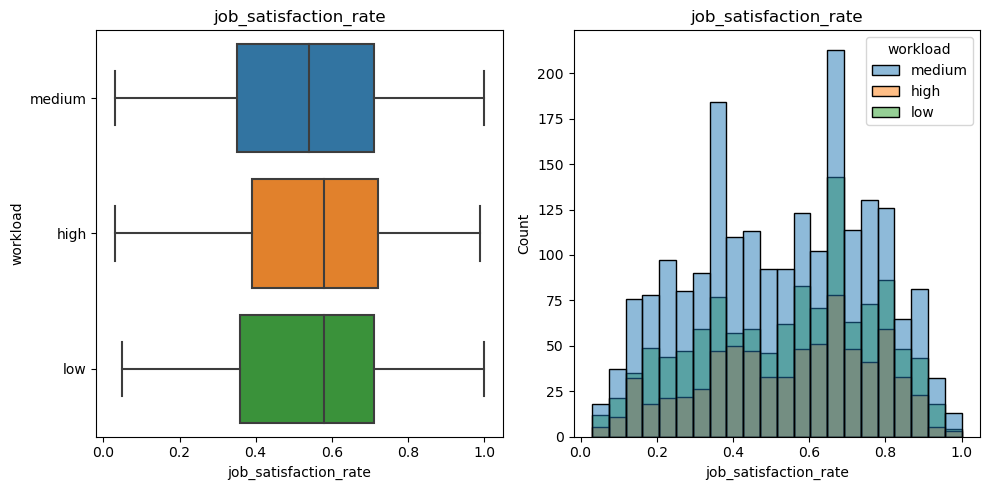

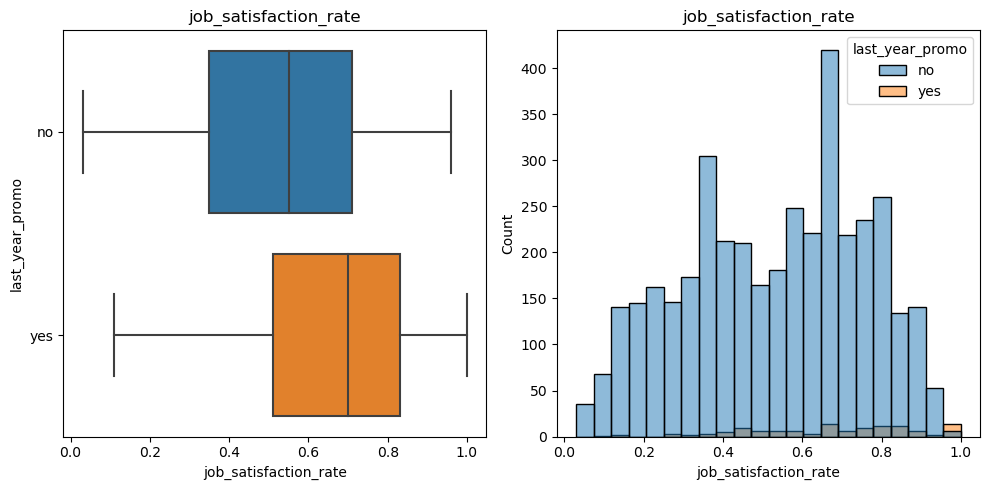

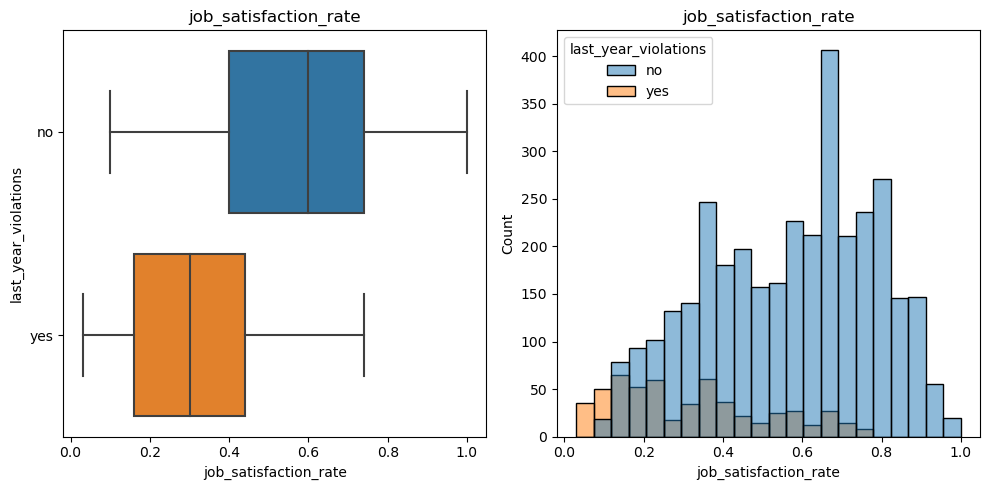

In [8]:
job_satisfaction_num = job_satisfaction_rate[['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']]

for i, num in enumerate(job_satisfaction_num):
    for j, cat in enumerate(job_satisfaction_cat):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        plot_num_data(job_satisfaction_rate, num, job_satisfaction_cat[cat], num, axs[0])
        hist_num_data(job_satisfaction_rate, num, job_satisfaction_cat[cat], num, axs[1])
        fig.tight_layout()
        plt.show()

Наблюдения по распределениям количественных признаков, которые могут потом пригодится:
- Повышение получают джуниоры с опытом 1,3 годами, мидлы с 4-6 годами
- Нарушения правил ТД есть во всех категориях
- Некоторым работникам начальники дают низкую оценку, даже если у тех высокая загрузка
- Повышают даже тех работников, которых руководители оценили на 2 и 3 
- Тем, кто нарушил ТД, руководители давали достаточно большую оценку - 3 и 4
- Отдел продаж - самый большой отдел, но и начальные зарплаты там самые низкие
- Некоторые мидлы и синьоры получают наравне с джунами
- У отдела продаж, технологий и hr самая нижняя граница удовлетворённости
- Достаточно много низкой удовлетворённости по всем уровням
- Те, у кого низкая удовлетворённость, совершают больше нарушений ТД

## Корелляционный анализ

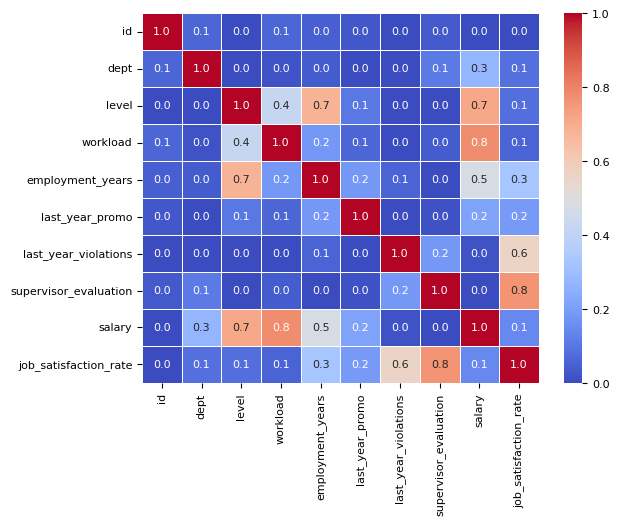

In [9]:
phik_matrix = job_satisfaction_rate.phik_matrix(interval_cols = ['id', 'employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'])
plt.rcParams['font.size'] = '8'
sns.heatmap(phik_matrix, annot=True, linewidth=.5, fmt=".1f", cmap='coolwarm')
plt.show()

Мультиколлинеарности между входными признаками не наблюдается, коэффициенты корреляции между ними ниже 0.9. Есть сильная зависимость между уровнем и зарплатой, уровнем и годами опыта, загруженностью и зарплатой, оценкой руководителя и удовлетворённостью работой. 

## Пайплайн обработки данных и обучения моделей

Уберу id из датасета, для обучения они не нужны

In [10]:
# полностью удалять столбец с id из датасета не стоит, поэтому сделаю из id индексы
job_satisfaction_rate.set_index('id', inplace=True)
job_satisfaction_rate.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [11]:
job_satisfaction_rate.duplicated().sum()

245

In [12]:
# в датасете появились дубликаты, для обучения они не нужны, поэтому тоже удалю
job_satisfaction_rate = job_satisfaction_rate.drop_duplicates()
job_satisfaction_rate.duplicated().sum()

0

Потребуются следующие преобразования значений перед обучением:

Кодировка 'dept', 'last_year_promo', 'last_year_violations' с помощью OneHotEncoder.
Кодировка 'level', 'workload', 'supervisor_evaluation' c помощью OrdinalEncoder
Кодировка 'salary', 'employment_years' с помощью StandardScaler
Для проверки качества модели - метрика SMAPE. Её расчёт ещё нужно написать.



In [13]:
def smape(y_test, y_pred):
    return (100/len(y_test) * np.sum(2 * np.abs(y_pred - y_test) / (np.abs(y_test) + np.abs(y_pred))))


smape_scorer = make_scorer(smape, greater_is_better=False)

RANDOM_STATE = 42
TEST_SIZE = 0.25

X = job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y = job_satisfaction_rate['job_satisfaction_rate']

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload', 'supervisor_evaluation']
num_columns = ['salary', 'employment_years']

ohe_pipe = Pipeline(
    [('simpleImputer_ohe1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), ('simpleImputer_ohe_2', SimpleImputer(missing_values=' ', strategy='most_frequent')), ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])


ord_pipe = Pipeline(
    [('simpleImputer_before_ord1', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), ('simpleImputer_before_ord2', SimpleImputer(missing_values=' ', strategy='most_frequent')), ('ord', OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['low', 'medium', 'high'], [1, 2, 3, 4, 5]]))])

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
)

pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

param_distributions = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 20),
        'models__min_samples_split': range(2, 20),
        'models__min_samples_leaf': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    cv=5,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search.fit(X, y)

best_model = randomized_search.best_estimator_

best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe1',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe_2',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year...
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high'],
                                                                                              [1,
                                                                                               2,
                                                                                               3,
                                                                                               4,
                                                                                               5]]))]),
                                                  ['level', 'workload',
                                                   'supervisor_evaluation']),
                                                 ('num', 'passthrough',
                                                  ['salary',
                                                   'employment_years'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=12, min_samples_leaf=2,
                                       min_samples_split=9, random_state=42))])

In [14]:
result = pd.DataFrame(randomized_search.cv_results_)
print(result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score'))

pd.set_option('display.max_colwidth', 1000)

   rank_test_score                            param_models  mean_test_score  \
9                1  DecisionTreeRegressor(random_state=42)       -15.354395   
8                2  DecisionTreeRegressor(random_state=42)       -15.493605   
0                3  DecisionTreeRegressor(random_state=42)       -15.786319   
6                4  DecisionTreeRegressor(random_state=42)       -15.880703   
3                5  DecisionTreeRegressor(random_state=42)       -16.461294   
4                6  DecisionTreeRegressor(random_state=42)       -17.059632   
5                7  DecisionTreeRegressor(random_state=42)       -18.483106   
2                8  DecisionTreeRegressor(random_state=42)       -19.308319   
7                9  DecisionTreeRegressor(random_state=42)       -20.272369   
1               10  DecisionTreeRegressor(random_state=42)       -25.760461   

                                              params  
9  {'preprocessor__num': 'passthrough', 'models__...  
8  {'preprocessor__n

Лучшая модель для первой задачи - дерево решений с гиперпараметрами max_depth=15, min_samples_leaf=2, min_samples_split=3. На тренировочных данных метрика равна 15.

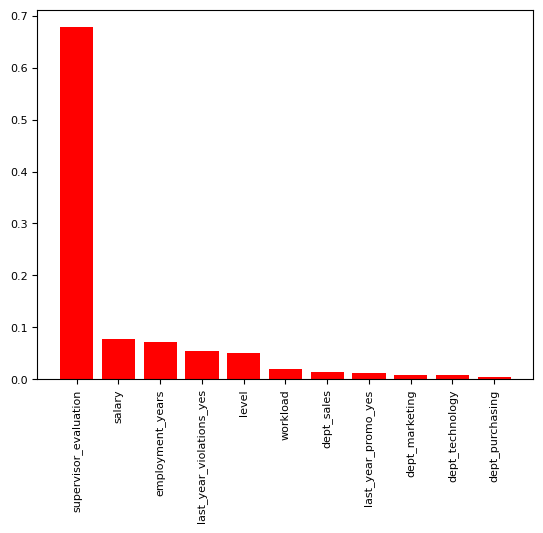

In [15]:
preprocessor = best_model.named_steps['preprocessor']
feature_names = []
for name, trans, column in preprocessor.transformers_:
    if name == 'ohe':
        feature_names.extend(trans.named_steps['ohe'].get_feature_names_out(column))
    elif name == 'ord':
        feature_names.extend(column)
    elif name == 'num':
        feature_names.extend(column)
feature_names = np.array(feature_names)
importances = best_model.named_steps['models'].feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.bar(feature_names[indices], importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical')
plt.show()

Больше всего на предсказания модели влияет значение оценки супервайзера. Если работник может видеть оценку супервайзера, то все несправедливые по мнению работника оценки будут восприниматься негативно и отрицательно влиять на мотивацию. По графикам также видно, что руководители часто неоправданно занижают или завышают оценки, например, тем, у кого большая нагрузка, или тем, кто нарушил трудовой договор.

In [16]:
test_features

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400


In [17]:
# в датасетах с входными признаками и целевыми не совпадают строки, поэтому объединяю датасеты и затем снова разделю их
test_data = test_features.merge(test_target_job_satisfaction_rate, on='id')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


In [18]:
test_data.set_index('id', inplace=True)

In [19]:
X_test = test_data.drop('job_satisfaction_rate', axis=1)
y_test = test_data['job_satisfaction_rate']

y_pred = best_model.predict(X_test)
smape_score = smape(y_test, y_pred)
smape_score

13.760091204890873

In [20]:
predictions = best_model.predict(test_data)
predictions

array([0.8448    , 0.67794872, 0.64333333, ..., 0.195     , 0.51857143,
       0.528     ])

Для предсказания удовлетворённости работой лучше всего подошло дерево решений. Значение удовлетворённости численное, поэтому решала задачу регрессии и использовала DecisionTreeRegressor. На тренирочных данных модель показывает значение метрики SMAPE равным 15, а на тестовых данных - около 13. С помощью RandomizedSearch подобрала гиперпараметры для дерева: максимальная глубина - 15, минимальное число объектов в листе - 2, минимальное количество выборок для разделения узла - 3. Больше всего на предсказания модели влияет значение оценки супервайзера. Значения зарплаты, стажа, нарушений ТД и грейда тоже влияют, но в значительно меньшей степени. 

## Загрузка и изучение данных для второй модели


In [21]:
try:
    train_quit = load_data('/Users/ira-bobrineva/Downloads/train_quit.csv')
except:
    train_quit = load_data('/datasets/train_quit.csv')

       id        dept   level workload  employment_years last_year_promo  \
0  723290       sales  middle     high                 2              no   
1  814010       sales  junior   medium                 2              no   
2  155091  purchasing  middle   medium                 5              no   
3  257132       sales  junior   medium                 2              no   
4  910140   marketing  junior   medium                 2              no   

  last_year_violations  supervisor_evaluation  salary quit  
0                   no                      4   54000   no  
1                   no                      4   27600   no  
2                   no                      1   37200   no  
3                  yes                      3   24000  yes  
4                   no                      5   25200   no  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------        

In [22]:
try:
    test_target_quit = load_data('/Users/ira-bobrineva/Downloads/test_target_quit.csv')
except:
    test_target_quit = load_data('/datasets/test_target_quit.csv')

       id quit
0  999029  yes
1  372846   no
2  726767   no
3  490105   no
4  416898  yes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [23]:
train_quit.duplicated().sum()

0

In [24]:
test_target_quit.duplicated().sum()

0

Данные нормальные, дубликатов, пропусков и неправильных типов данных нет.

## Исследовательский анализ данных

In [25]:
train_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no
3996,672059,sales,middle,high,9,no,no,4,52800,no
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no


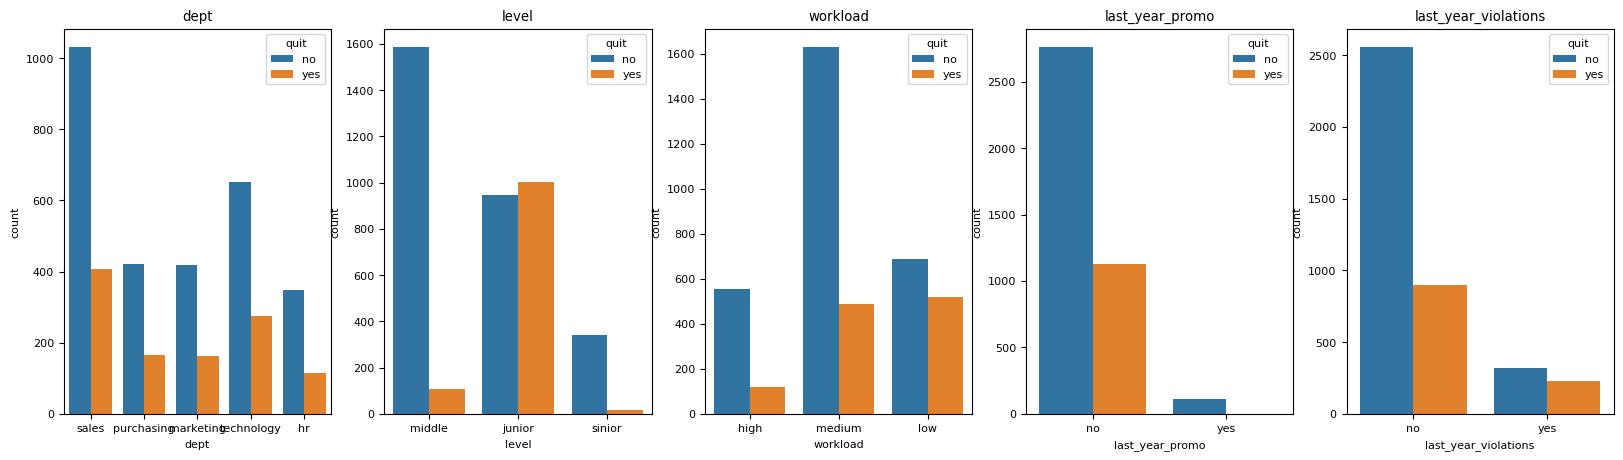

In [26]:
train_quit_cat = train_quit[['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']]

fig, axs = plt.subplots(1, len(train_quit_cat.columns) - 1, figsize=(20, 5))

for i, cat in enumerate(train_quit_cat):
    if cat != 'quit':
        plot_cat_data(train_quit_cat, cat, 'quit', cat, axs[i])

Больше всего увольнений в отделе продаж, но и людей там больше всего. Очень большая доля увольнений с джуниорских позиций, что показывает и уровень загрузки: те, у кого небольшая загрузка, уйдут скорее всего. Повышения мотивируют людей оставаться: поскольку в компании редко повышают, то и уровень увольнений среди тех, кого не повысили, высок. Странновато и то, что компания не увольняет сразу сотрудников, которые нарушили трудовой договор.

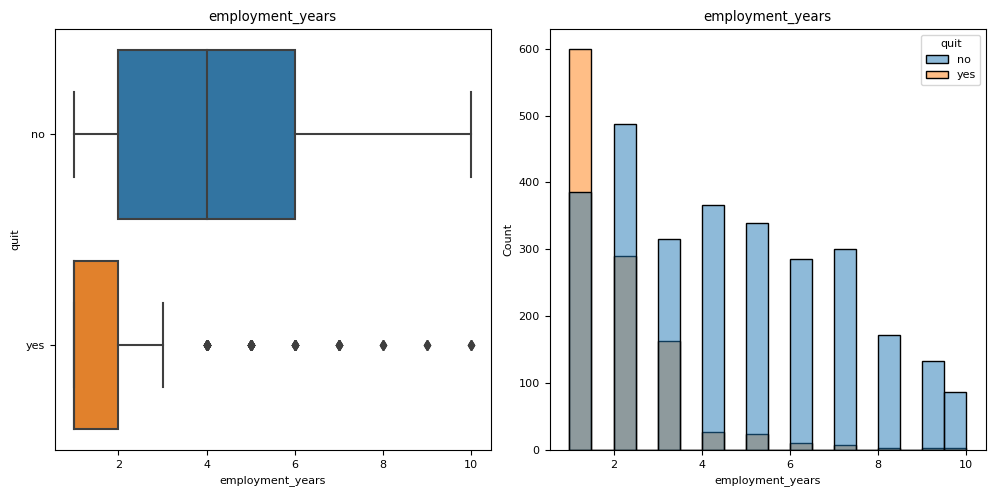

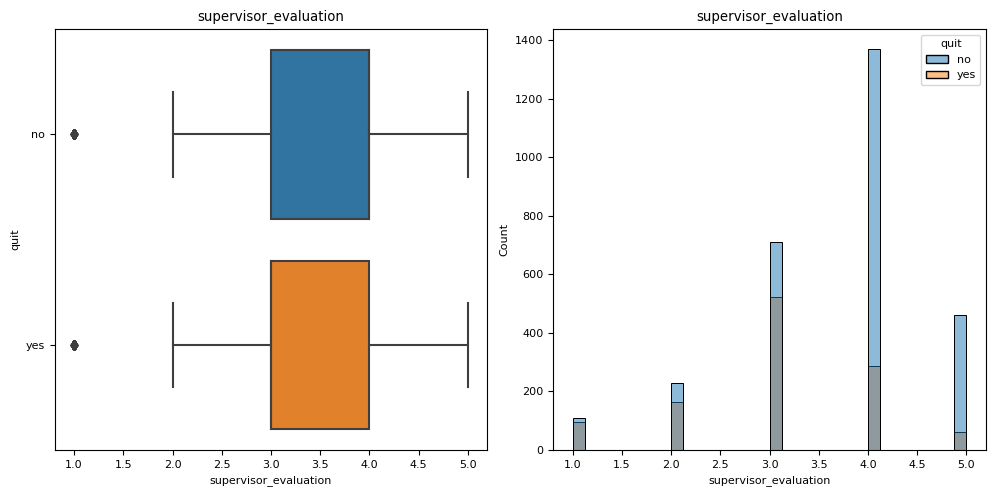

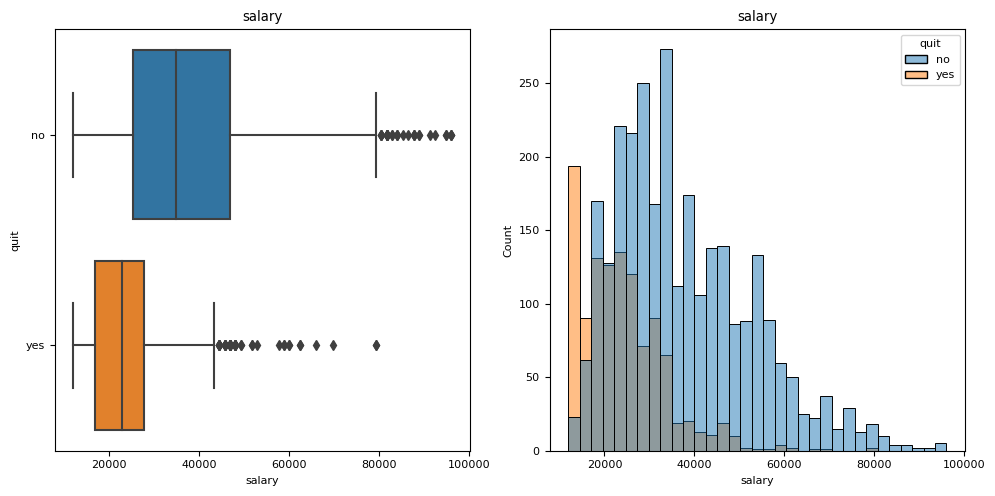

In [27]:
train_quit_num = train_quit[['employment_years', 'supervisor_evaluation', 'salary']]

for i, num in enumerate(train_quit_num):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plot_num_data(train_quit_num, num, train_quit['quit'], num, axs[0])
    hist_num_data(train_quit_num, num, train_quit['quit'], num, axs[1])
    fig.tight_layout()
    plt.show()

Стаж работы тех, кто уволился, соотносится с большим количеством увольнений среди джуниоров - в среднем увольняются те, кто проработал меньше трёх лет. Зарплата также влияет на решение сотрудника, остаться или нет. Больше всего увольнений среди тех сотрудников, у которых зарплата меньше 40 000 рублей.

In [28]:
#найду долю ушедших сотрудников
quit_share = len(train_quit.query('quit == "yes"')) / len(train_quit)
quit_share

0.282

Всего из компании ушло около 30% сотрудников. Это высокий показатель. В интернетах говорят, что нормальная текучесть кадров — 3–7% в год.

In [29]:
test_targets = test_target_job_satisfaction_rate.merge(test_target_quit)
test_targets

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes
...,...,...,...
1995,405257,0.28,no
1996,370925,0.21,yes
1997,857722,0.39,no
1998,303402,0.26,yes


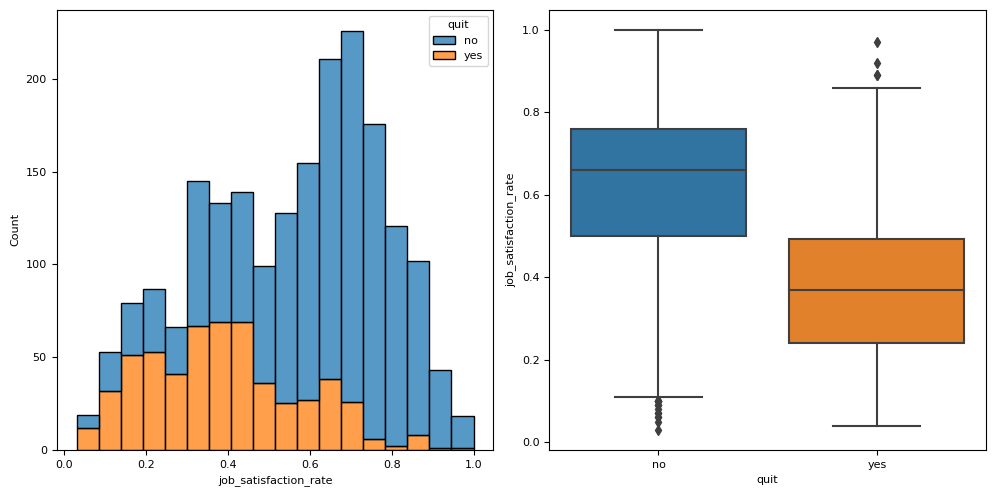

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(data=test_targets, ax=axs[0], x='job_satisfaction_rate', hue='quit', multiple='stack')
sns.boxplot(data=test_targets, ax=axs[1], x='quit', y='job_satisfaction_rate')
fig.tight_layout()
plt.show()

С аналитиками можно согласиться: по графикам действительно получается, что те, у кого низкая удовлётворённость работой, скорее всего уйдут.

## Добавление нового входного признака

In [31]:
# предсказание job_satisfaction_rate для тестового набора данных по увольнениям
test_features.set_index('id', inplace=True)
test_features['job_satisfaction_rate'] = best_model.predict(test_features)
test_features

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.844800
686555,hr,junior,medium,1,no,no,4,30000,0.677949
467458,sales,middle,low,5,no,no,4,19200,0.643333
418655,sales,middle,low,6,no,no,4,19200,0.663750
789145,hr,middle,medium,5,no,no,5,40800,0.816098
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.500476
109582,technology,middle,low,3,no,no,2,21600,0.151429
305653,technology,junior,low,1,no,no,3,14400,0.195000


In [32]:
test_target_quit

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
...,...,...
1995,836109,yes
1996,180999,yes
1997,746018,no
1998,247658,no


In [33]:
train_quit.set_index('id', inplace=True)
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit.drop(['quit'], axis=1))
train_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.651778
814010,sales,junior,medium,2,no,no,4,27600,no,0.836087
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.360000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.333750
910140,marketing,junior,medium,2,no,no,5,25200,no,0.804444
...,...,...,...,...,...,...,...,...,...,...
588809,sales,junior,medium,4,no,no,3,26400,no,0.517000
672059,sales,middle,high,9,no,no,4,52800,no,0.835000
536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.544286


In [34]:
train_quit.duplicated().sum()

1413

In [35]:
# во входных признаках тоже появились дубликаты, уберу их перед обучением
train_quit = train_quit.drop_duplicates()
train_quit.duplicated().sum()

0

In [36]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

le = LabelEncoder()
train_quit['quit'] = le.fit_transform(train_quit['quit'])

X_train_2 = train_quit.drop(['quit', 'dept'], axis=1) # убрала департамент из тренировочного набора, потому что у этого признака нулевая значимость для модели
y_train_2 = train_quit['quit']                  


ohe_columns_2 = ['last_year_promo', 'last_year_violations']
ord_columns_2 = ['level', 'workload', 'supervisor_evaluation']
num_columns_2 = ['salary', 'employment_years', 'job_satisfaction_rate']

ohe_pipe_2 = Pipeline(
    [('simpleImputer_ohe3', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), ('simpleImputer_ohe4', SimpleImputer(missing_values=' ', strategy='most_frequent')), ('ohe2', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])


ord_pipe_2 = Pipeline(
    [('simpleImputer_before_ord3', SimpleImputer(missing_values=np.nan, strategy='most_frequent')), ('simpleImputer_before_ord4', SimpleImputer(missing_values=' ', strategy='most_frequent')), ('ord2', OrdinalEncoder(categories=[['junior', 'middle', 'sinior'], ['low', 'medium', 'high'], [1, 2, 3, 4, 5]]))])

data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe2', ohe_pipe_2, ohe_columns_2),
        ('ord2', ord_pipe_2, ord_columns_2),
        ('num2', StandardScaler(), num_columns_2)
    ],
    remainder='passthrough'
)

pipe_final_2 = Pipeline(
    [
        ('preprocessor2', data_preprocessor_2),
        ('models2', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

param_distributions_2 = [
    # словарь для модели KNeighborsClassifier() 
    {

        'models2': [KNeighborsClassifier()],

        'models2__n_neighbors': range(1, 20),
        #
        'preprocessor2__num2': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models2': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models2__max_depth': range(2, 11),
        'models2__min_samples_split': range(2, 11),
        'models2__min_samples_leaf': range(1, 11),
        'preprocessor2__num2': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models2': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models2__C': range(1, 5),
        'preprocessor2__num2': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    }
]


randomized_search_2 = RandomizedSearchCV(
    pipe_final_2,
    param_distributions=param_distributions_2,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)
randomized_search_2.fit(X_train_2, y_train_2)

best_model_2 = randomized_search_2.best_estimator_

best_model_2


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Pipeline(steps=[('preprocessor2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe2',
                                                  Pipeline(steps=[('simpleImputer_ohe3',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('simpleImputer_ohe4',
                                                                   SimpleImputer(missing_values=' ',
                                                                                 strategy='most_frequent')),
                                                                  ('ohe2',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_yea...
                                                                                 strategy='most_frequent')),
                                                                  ('ord2',
                                                                   OrdinalEncoder(categories=[['junior',
                                                                                               'middle',
                                                                                               'sinior'],
                                                                                              ['low',
                                                                                               'medium',
                                                                                               'high'],
                                                                                              [1,
                                                                                               2,
                                                                                               3,
                                                                                               4,
                                                                                               5]]))]),
                                                  ['level', 'workload',
                                                   'supervisor_evaluation']),
                                                 ('num2', MinMaxScaler(),
                                                  ['salary', 'employment_years',
                                                   'job_satisfaction_rate'])])),
                ('models2',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=5,
                                        min_samples_split=5,
                                        random_state=42))])

In [37]:
result_2 = pd.DataFrame(randomized_search_2.cv_results_)
print(result_2[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score'))

pd.set_option('display.max_colwidth', 1000)

   rank_test_score  mean_test_score  \
2                1         0.897721   
4                2         0.897053   
3                3         0.897039   
1                4         0.896831   
8                5         0.896402   
9                6         0.893398   
0                7         0.888660   
6                8         0.886251   
5                9         0.884610   
7               10         0.884302   

                                                                                                                                                                                    params  
2    {'preprocessor2__num2': MinMaxScaler(), 'models2__min_samples_split': 5, 'models2__min_samples_leaf': 5, 'models2__max_depth': 5, 'models2': DecisionTreeClassifier(random_state=42)}  
4    {'preprocessor2__num2': RobustScaler(), 'models2__min_samples_split': 9, 'models2__min_samples_leaf': 9, 'models2__max_depth': 4, 'models2': DecisionTreeClassifier(random_state=42)}  
3  

Лучшая модель - DecisionTreeClassifier с гиперпараметрами max_depth=4, min_samples_leaf=3, min_samples_split=4.

In [38]:
# проверю, что кодировщик верно закодировал значения целевой переменной
le.classes_

array(['no', 'yes'], dtype=object)

In [39]:
# снова объединю датасеты с входными и целевыми признаками, чтобы соотнести строки по айди
test_features.reset_index(inplace=True)

data_test_quit = test_features.merge(test_target_quit, on='id')
data_test_quit

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.844800,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.677949,no
2,467458,sales,middle,low,5,no,no,4,19200,0.643333,no
3,418655,sales,middle,low,6,no,no,4,19200,0.663750,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.816098,no
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.500476,yes
1996,109582,technology,middle,low,3,no,no,2,21600,0.151429,yes
1997,305653,technology,junior,low,1,no,no,3,14400,0.195000,yes
1998,160233,technology,middle,low,8,no,no,1,32400,0.518571,no


In [40]:
# обучаю модель на новых данных

data_test_quit.set_index('id', inplace=True)

data_test_quit['quit'] = le.transform(data_test_quit['quit'])

X_test_quit = data_test_quit.drop(['quit', 'dept'], axis=1)
y_test_quit = data_test_quit['quit']

y_pred_2 = best_model_2.predict_proba(X_test_quit)[:,1]
roc_auc = roc_auc_score(y_test_quit, y_pred_2)
roc_auc

0.9195058920563425

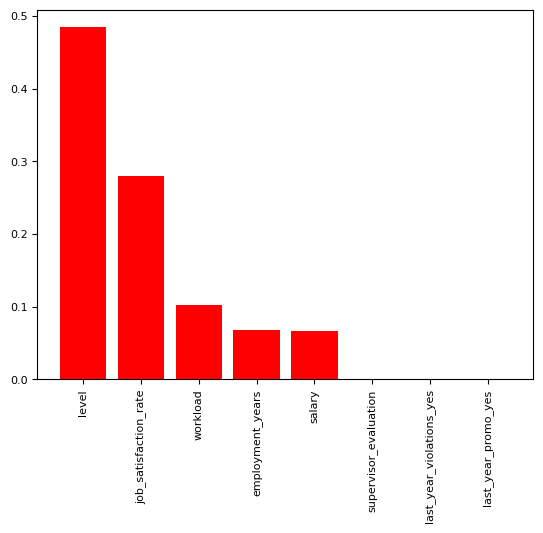

In [41]:
preprocessor = best_model_2.named_steps['preprocessor2']
feature_names = []
for name, trans, column in preprocessor.transformers_:
    if name == 'ohe2':
        feature_names.extend(trans.named_steps['ohe2'].get_feature_names_out(column))
    elif name == 'ord2':
        feature_names.extend(column)
    elif name == 'num2':
        feature_names.extend(column)
feature_names = np.array(feature_names)
importances = best_model_2.named_steps['models2'].feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.bar(feature_names[indices], importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), feature_names[indices], rotation='vertical')
plt.show()

Задача для предсказаний - бинарная классификация. Лучше всего с предсказаниями тоже справилось дерево решений - DecisionTreeClassifier. Лучшие гиперпараметры для модели следующие: максимальная глубина - 4, минимальное число объектов в листе - 3, минимальное количество выборок для разделения узла - 4. На тренировочных данных модель показывает значение roc_auc равное 89, а на тестовых - 91,9. 
На предсказания модели сильно влияют значения грейда, удовлетворённостью работой, стаж и загрузка. По графикам также было видно, что скорее всего уйдут джуниоры с небольшим стажем, люди с низкими удовлетворённостью работой, загрузкой и зарплатой.

In [42]:
data_test_quit['quit_probability'] = y_pred_2
data_test_quit

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit,quit_probability
id,,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.844800,0,0.153846
686555,hr,junior,medium,1,no,no,4,30000,0.677949,0,0.142857
467458,sales,middle,low,5,no,no,4,19200,0.643333,0,0.048387
418655,sales,middle,low,6,no,no,4,19200,0.663750,0,0.048387
789145,hr,middle,medium,5,no,no,5,40800,0.816098,0,0.014286
...,...,...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,0.500476,1,0.903846
109582,technology,middle,low,3,no,no,2,21600,0.151429,1,0.727273
305653,technology,junior,low,1,no,no,3,14400,0.195000,1,0.920000


## Общий вывод



 Задача состояла в том, чтобы создать две модели, которые бы предсказывали удовлетворённость работы и вероятность работника уволиться.

Я исследовала полученные данные:

- Изучила распределения категориальных и количественных значений
- Исследовала мультиколлинеарность
- Убрала id из датасетов перед обучением модели, а затем удалила дубликаты
- В пайплайне заполнила пропуски, закодировала численные и категориальные значения

В первом пайплайне (предсказание удовлетворённости) перебрала две модели — дерево решений и линейную регрессию. Эти модели можно использовать для задачи регрессии. Лучшая модель — дерево решений, потому что у него больше настроек, которые могут точнее настроить модель.

Больше всего на предсказания модели влияет значение оценки супервайзера. Если работник может видеть оценку супервайзера, то все несправедливые по мнению работника оценки будут восприниматься негативно и отрицательно влиять на мотивацию. По графикам также видно, что руководители часто неоправданно занижают или завышают оценки, например, тем, у кого большая нагрузка, или тем, кто нарушил трудовой договор.

**Совет:** компании надо провести оценку работы руководителей. Видно, что руководители не совсем справедливо оценивают подчинённых, что может отражаться на удовлетворённостью работой.

Во втором пайплайне (предсказание увольнения) перебрала три модели — KNeighborsClassifier, дерево решений и логистическую регрессиию. Лучшая модель — снова дерево решений.

На предсказания модели сильно влияют значения грейда, удовлетворённостью работой, стаж и загрузка. По графикам также было видно, что скорее всего уйдут джуниоры с небольшим стажем, люди с низкими удовлетворённостью работой, загрузкой и зарплатой.

**Совет:** компании надо стремиться удерживать новичков. Сейчас видно, что у многих работников с небольшим стажем низкие зарплаты и очень низкая вероятность получить повышение. Это также распространяется и на многих мидлов. В совокупности с несправедливой оценкой от руководителя это сильно демотивирует работников.